## 🏥 Public Healthcare Organization Data – Pipeline Summary

This notebook demonstrates an end-to-end ETL process for healthcare organization data scraped from HIRA.  
It includes data loading, cleaning (with regular expressions), and preparation for analysis.

---

#### 🔄 Summary of Processing Steps

1. **Full HCO Data** – Load & clean hospital/clinic data (excluding clinics)  
2. **Clinic Department Data** – Merge & deduplicate department-specific clinic info  
3. **General Hospital Detail** – Parse doctor/specialty data for large hospitals  

Each step outputs structured DataFrames used in later analysis.

<details>
<summary>📄 Detailed Data Info (Click to expand)</summary>

🔹 **Step 1: Full HCO Data**  
- Path: `data/hco/`  
- Format: `.xlsx` files (10 types)  
- Output: `hco_all_df`

🔹 **Step 2: Clinic Data**  
- Path: `data/clinic/`  
- Format: `.xlsx` files (24 departments)  
- Output:  
  - `hco_clinic_df`: merged, deduplicated data  

🔹 **Step 3: Hospital Detail Data**  
- Path: `data/hco_detail/`  
- Format: recent `.csv` files  
- Output: `hco_detail_df` (structured doctor/specialty info)

</details>

---

Data is cleaned using `pandas` and `re`, then prepared for insight generation or cloud upload (simulated AWS S3).


#### [Basic] Import Required Libraries

In [32]:
import os
from datetime import datetime
import pandas as pd
import re
import warnings
from collections import defaultdict

# Visualization libraries
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# AWS S3 interaction (for simulated cloud upload)
import boto3
from botocore.exceptions import NoCredentialsError

# Custom utility functions for ETL processing
from utils.analysis_utils import (
    load_and_merge_files,          # Load and combine multiple files from a folder
    extract_doctor_counts,        # Extract numeric doctor data from text fields
    seperate_data,                # Extract metadata (e.g., dept) from filename
    extract_region_info,          # Extract province/city from full address
    get_top_hospitals_by_staff,   # Analyze top hospitals by medical staff size
    upload_to_s3                  # Load final_dataset to S3
)

# Mapping dictionaries for consistent formatting and translation
from config.mapping_info import (
    column_mapping,                  # Korean → English column rename mapping
    department_mapping_snake_case,   # Medical departments → snake_case conversion
    category_mapping,                # HIRA hospital categories normalization
    province_mapping                 # Region name translation/normalization
)

# Suppress all warnings for clean output
warnings.filterwarnings('ignore')

# Timestamp info used in saved filenames
date_info = datetime.now().strftime("%Y%m%d_%H%M")

#### [Basic] Define Folder Paths

In [33]:
# Root working directory (should be the notebook's location)
base_dir = os.getcwd()

# Main Folder for data
data_folder = os.path.join(base_dir, "data")
# Folder containing general hospital & pharmacy data (.xlsx, 10 types)
hco_data_dir = os.path.join(base_dir, "data", "hco")

# Folder containing clinic data split by department (.xlsx, 24 files)
clinic_data_dir = os.path.join(base_dir, "data", "clinic")  

# Folder containing detailed doctor/specialty data (.csv)
detail_dir = os.path.join(base_dir, "data", "hco_detail")

# Folder to save cleaned and processed datasets
saving_folder = os.path.join(base_dir, "data", "final_dataset")
os.makedirs(saving_folder, exist_ok=True)

#### 1. Load Raw Data Files (ETL – Extract)

In [65]:
# Load all general hospital/pharmacy data (.xlsx files from 'data/')
hco_all_df = load_and_merge_files(hco_data_dir, file_type="xlsx")
# Load all clinic department data (.xlsx files from 'clinic_data/')
hco_clinic_df = load_and_merge_files(clinic_data_dir, file_type="xlsx")
# Load top 2 most recent detail files (.csv) from 'hco_detail/'
hco_detail_df = load_and_merge_files(detail_dir, file_type="csv", max_files=2, sort_by_time=True)

📁 Found 10 XLSX file(s) to load:
 - 병원_auto_20250516_1421.xlsx
 - 보건기관_auto_20250516_1421.xlsx
 - 상급종합병원_auto_20250516_1421.xlsx
 - 약국_auto_20250516_1421.xlsx
 - 요양병원_auto_20250516_1421.xlsx
 - 정신병원_auto_20250516_1421.xlsx
 - 조산원_auto_20250516_1421.xlsx
 - 종합병원_auto_20250516_1421.xlsx
 - 치과_auto_20250516_1421.xlsx
 - 한방_auto_20250516_1421.xlsx
✅ Merged shape: (67048, 8)
📁 Found 24 XLSX file(s) to load:
 - 의원_auto_가정의학과_20250516_1945.xlsx
 - 의원_auto_결핵과_20250516_1945.xlsx
 - 의원_auto_내과_20250516_1945.xlsx
 - 의원_auto_마취통증의학과_20250516_1945.xlsx
 - 의원_auto_미표시_20250516_1945.xlsx
 - 의원_auto_병리과_20250516_1945.xlsx
 - 의원_auto_비뇨의학과_20250516_1945.xlsx
 - 의원_auto_산부인과_20250516_1945.xlsx
 - 의원_auto_성형외과_20250516_1945.xlsx
 - 의원_auto_소아청소년과_20250516_1945.xlsx
 - 의원_auto_신경과_20250516_1945.xlsx
 - 의원_auto_신경외과_20250516_1945.xlsx
 - 의원_auto_안과_20250516_1945.xlsx
 - 의원_auto_영상의학과_20250516_1945.xlsx
 - 의원_auto_예방의학과_20250516_1945.xlsx
 - 의원_auto_외과_20250516_1945.xlsx
 - 의원_auto_이비인후과_20250516_1945.xlsx

#### 2. Data Cleaning & Transformation & Saving
>This step prepares raw scraped datasets for downstream analytics by applying renaming, deduplication, and feature extraction using regular expressions.

**✅ Cleaned Datasets:**
- `hco_all_df`: General healthcare data (excluding clinics)
- `hco_clinic_df`: Clinic data with departments extracted
- `hco_detail_df`: Specialty & doctor count info from large hospitals

---

<details>
<summary>📍 Cleaning Steps (Details)</summary>

1. **General + Clinic Data (`hco_all_df`, `hco_clinic_df`)**
   - Rename all columns from Korean to English
   - Extract department info from file names in clinic data
   - Remove duplicates based on hospital name, phone, and postal code
   - Merge both datasets into a unified `hco_all_merged`
   - Extract `province` and `city` from address strings using regex

2. **Hospital Detail Data (`hco_detail_df`)**
   - Parse number of doctors, dentists, and Korean medics using regex
   - Extract hospital category (tertiary/general) from filename
   - Parse specialties with counts into individual columns
   - Create new specialty columns dynamically and fill with counts
   - Rename specialty columns into consistent snake_case format
   - Merge geographic info (province, city) using hospital name

</details>

These cleaned datasets will be used for descriptive statistics and geospatial visualizations.

+ Cleaning – General + Clinic Data (`hco_all_df`, `hco_clinic_df`)

In [66]:
# 1. Rename all columns from Korean to English
hco_all_df.rename(columns=column_mapping, inplace=True)
hco_clinic_df.rename(columns=column_mapping, inplace=True)
hco_detail_df.rename(columns=column_mapping, inplace=True)

print("✅ Columns renamed:")
print("hco_all:", hco_all_df.columns.tolist())
print("hco_clinic:", hco_clinic_df.columns.tolist())
print("hco_detail:", hco_detail_df.columns.tolist())


# 2. Extract department info from clinic source_file column
# (e.g., "clinic_internal_medicine.xlsx" → "internal_medicine")
seperate_data(hco_clinic_df, column_name_new="department", column_name_raw="source_file", num=3)

# 3. Remove duplicates in clinic data by key identifiers
hco_clinic_df.drop_duplicates(
    subset=['hospital_name', 'phone', 'postal_code'],
    keep='first',
    inplace=True
)

# 4. Merge all hospital & clinic datasets into one
hco_all_merged = pd.concat([hco_all_df, hco_clinic_df], ignore_index=True)
hco_all_merged.drop(columns='source_file', inplace=True)

# 5. Extract 'province' and 'city' from address field using regex
hco_all_merged[["province", "city"]] = hco_all_merged["address"].apply(extract_region_info)

# Rename 강원도 → 강원특별자치도 for consistency
hco_all_merged.loc[hco_all_merged['province'] == '강원도', 'province'] = '강원특별자치도'

✅ Columns renamed:
hco_all: ['NO', 'hospital_name', 'category', 'phone', 'postal_code', 'address', 'homepage_address', 'source_file']
hco_clinic: ['NO', 'hospital_name', 'category', 'phone', 'postal_code', 'address', 'homepage_address', 'source_file']
hco_detail: ['NO', 'hospital_name', 'ykiho', 'doctor_info', 'specialties', 'source_file']


+ Cleaning - Hospital Detail Data (`hco_detail_df`)

In [67]:
# 1. Extract doctor counts (3 types) using regex pattern
hco_detail_df[['num_doctors', 'num_dentists', 'num_korean_med']] = hco_detail_df['doctor_info'].apply(
    extract_doctor_counts
)

# 2. Extract hospital category (e.g., tertiary/general) from filename
seperate_data(hco_detail_df, column_name_new="category", column_name_raw="source_file", num=3)

# 3. Parse all unique specialties from text format into a set
all_specialties = hco_detail_df["specialties"].dropna().to_list()
dept_set = set()
for row in all_specialties:
    matches = re.findall(r"([^,()]+)\s*\(\d+\)", row)
    dept_set.update([dept.strip() for dept in matches])

# 4. Create new specialty columns (one per department) initialized with 0
for dept in dept_set:
    hco_detail_df[dept] = 0

# 5. Fill specialty columns with extracted doctor counts
for idx, row in hco_detail_df.iterrows():
    if pd.isna(row["specialties"]):
        continue
    matches = re.findall(r"([^,()]+)\s*\((\d+)\)", row["specialties"])
    for dept, count in matches:
        dept = dept.strip()
        if dept in dept_set:
            hco_detail_df.at[idx, dept] = int(count)

# 6. Rename all department columns to snake_case format
hco_detail_df.rename(columns=department_mapping_snake_case, inplace=True)

# 7. Create total medical staff column (sum of 3 types)
hco_detail_df['total_medical_staff'] = hco_detail_df[['num_doctors', 'num_dentists', 'num_korean_med']].sum(axis=1)

# 8. Add English category mapping
hco_detail_df["category_en"] = hco_detail_df['category'].map(category_mapping)

# 9. Merge with location info from all hospitals (province, city)
hco_detail_merged = pd.merge(
    hco_detail_df,
    hco_all_merged[['hospital_name', 'province', 'city']],
    how='left',
    on='hospital_name'
)

print("📌 Total department columns created:", len(dept_set))


📌 Total department columns created: 42


#### 3. Save Cleaned Datasets (with timestamp)

In [50]:
# Save cleaned datasets into the specified final folder with timestamped filenames
hco_all_merged.to_csv(os.path.join(saving_folder,f"hco_all_df_{date_info}.csv"),index=False)
hco_detail_merged.to_csv(os.path.join(saving_folder,f"hco_detail_merged_{date_info}.csv"),index=False)

#### 4. Cloud Integration Readiness (Simulated)

To demonstrate end-to-end pipeline capability, the final processed dataset is uploaded to a simulated AWS S3 bucket.

> ⚠️ **Note**: This upload assumes an AWS environment is configured (via `boto3` and access keys). This step is a simulated example and **does not perform real deployment**. It aims to show **cloud readiness** for production pipelines.


In [ ]:
# === Simulated AWS S3 Upload (for demonstration purposes only) ===
# This function simulates uploading a file to AWS S3
# Replace credentials and paths with actual values in production

upload_to_s3(
    file_path=os.path.join(saving_folder, f"hco_all_df_{date_info}.csv"),
    bucket_name="veeva-demo-bucket",  # Simulated bucket name
    s3_path=f"hco/hco_all_df_{date_info}.csv"
)

---

#### 1. Analysis: Number and Rate of HCOs by Category

In [68]:
# === Group by HCO category and count hospital names ===
num_hco = hco_all_merged.groupby('category')['hospital_name'].count().reset_index(name='count')

# === Calculate percentage share per category ===
num_hco['rate(%)'] = round((num_hco['count'] / len(hco_all_merged)) * 100, 2)

# === Map Korean category names to English ===
num_hco["category_en"] = num_hco["category"].map(category_mapping)

# === Reorder and rename columns ===
num_hco = num_hco[["category_en", "category", "count", "rate(%)"]]
num_hco.columns = ["category_en", "category_ko", "count", "rate(%)"]

# === Sort categories by share in descending order ===
num_hco.sort_values(by='rate(%)', ascending=False, inplace=True)

num_hco


,category_en,category_ko,count,rate(%)
8,clinic,의원,37196,35.68
6,pharmacy,약국,25305,24.27
13,dental_clinic,치과의원,19223,18.44
15,oriental_clinic,한의원,14796,14.19
4,public_health_center_branch,보건진료소,1895,1.82
0,hospital,병원,1434,1.38
7,nursing_hospital,요양병원,1332,1.28
3,public_health_subcenter,보건지소,1306,1.25
14,oriental_hospital,한방병원,594,0.57
11,general_hospital,종합병원,331,0.32


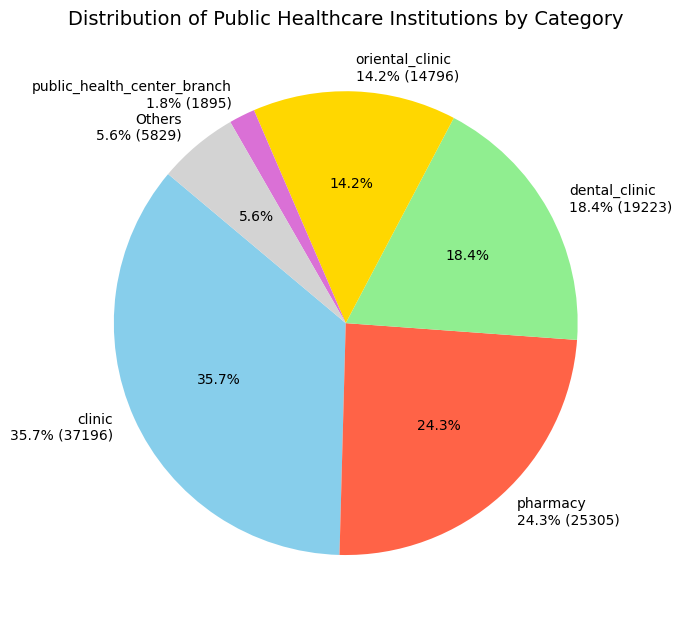

In [69]:
# === Prepare pie chart data ===
df = num_hco.copy()
df = df.sort_values(by="rate(%)", ascending=False)

# === Define how many top categories to highlight ===
top_n = 5
df_top = df.head(top_n).copy()
df_others = df.iloc[top_n:].copy()

# === Summarize all other categories into "Others" row ===
others = pd.DataFrame({
    "category_en": ["Others"],
    "category_ko": ["기타"],
    "count": [df_others["count"].sum()],
    "rate(%)": [df_others["rate(%)"].sum()]
})

# === Merge top categories with "Others" row ===
df_final = pd.concat([df_top, others], ignore_index=True)

# === Create label text for pie chart (category + % + count) ===
df_final["label"] = df_final.apply(
    lambda row: f'{row["category_en"]}\n{row["rate(%)"]:.1f}% ({int(row["count"])})', axis=1
)

# === Define custom colors to highlight major categories ===
colors = []
for cat in df_final["category_en"]:
    if cat == "pharmacy":
        colors.append("tomato")       # Highlight pharmacy
    elif cat == "clinic":
        colors.append("skyblue")
    elif cat == "dental_clinic":
        colors.append("lightgreen")
    elif cat == "oriental_clinic":
        colors.append("gold")
    elif cat == "public_health_center_branch":
        colors.append("orchid")
    else:
        colors.append("lightgray")    # Default for "Others"

# === Plot pie chart of HCO distribution by category ===
plt.figure(figsize=(7, 10))
wedges, texts, autotexts = plt.pie(
    df_final["count"],
    labels=df_final["label"],
    colors=colors,
    startangle=140,
    autopct=lambda pct: f"{pct:.1f}%" if pct > 2 else "",  # Skip labels for small slices
    textprops={"fontsize": 10}
)

plt.title("Distribution of Public Healthcare Institutions by Category", fontsize=14)
plt.tight_layout()
plt.show()

#### 2. Analysis: Regional Distribution of Public Healthcare Institutions

In [70]:
# === Group hospital count by province ===
province_counts = hco_all_merged.groupby("province")['hospital_name'].count().reset_index(name='count')

# === Calculate total number and share per province ===
total_hco = province_counts['count'].sum()
province_counts['rate(%)'] = (province_counts['count'] / total_hco * 100).round(2)

# === Map Korean province names to English ===
province_counts['province_ko'] = province_counts['province']
province_counts['province_en'] = province_counts['province'].map(province_mapping)

# === Reorder columns and sort by count ===
province_counts = province_counts[['province_en','province_ko', 'count', 'rate(%)']]
province_counts = province_counts.sort_values(by='count', ascending=False)

# ✅ Resulting DataFrame: province_counts
province_counts

,province_en,province_ko,count,rate(%)
8,Seoul,서울특별시,25149,24.13
1,Gyeonggi,경기도,23782,22.81
7,Busan,부산광역시,7323,7.02
2,Gyeongnam,경상남도,5648,5.42
5,Daegu,대구광역시,5611,5.38
11,Incheon,인천광역시,5157,4.95
3,Gyeongbuk,경상북도,4543,4.36
13,Jeonbuk,전북특별자치도,3941,3.78
15,Chungnam,충청남도,3873,3.72
12,Jeonnam,전라남도,3480,3.34


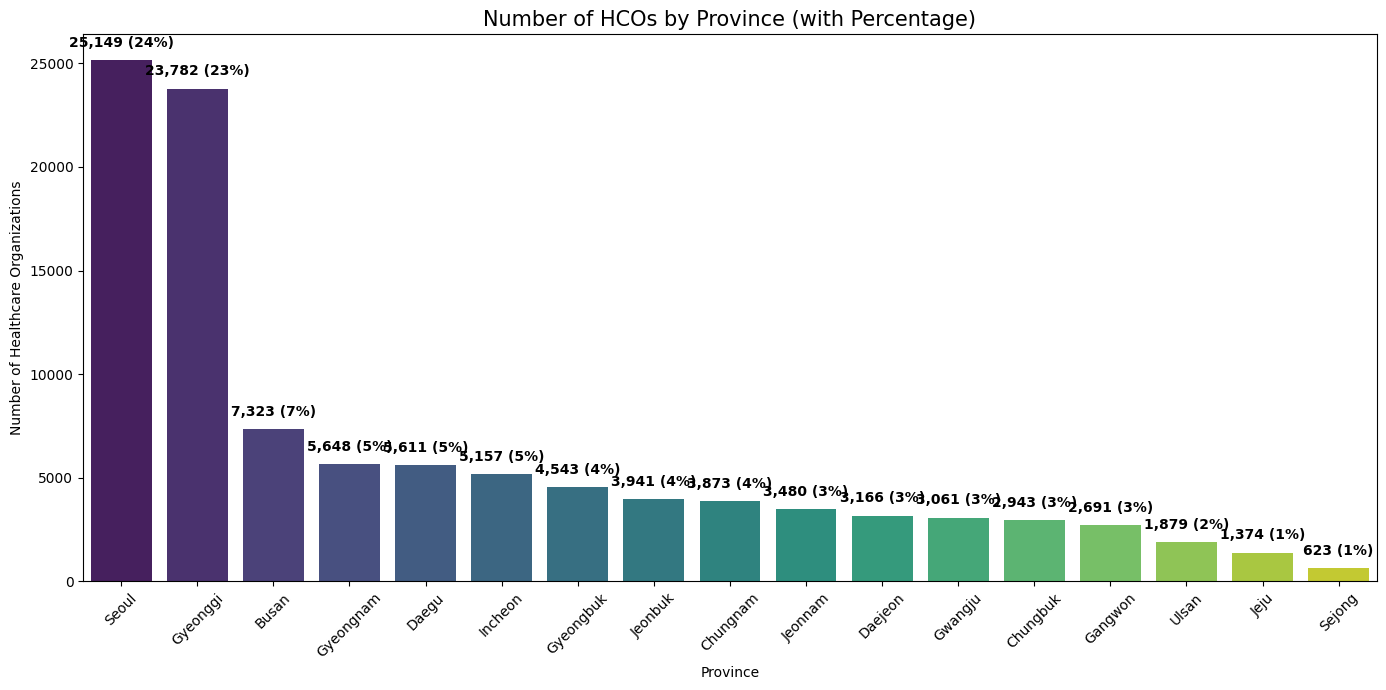

In [71]:
# === Set figure size and style ===
plt.figure(figsize=(14, 7))

# === Draw barplot of hospital count by region ===
barplot = sns.barplot(
    data=province_counts.sort_values(by="count", ascending=False),
    x='province_en',
    y='count',
    palette='viridis'
)

# === Add label above each bar ===
for i, row in province_counts.sort_values(by="count", ascending=False).reset_index().iterrows():
    barplot.text(
        i,
        row["count"] + 500,  # Slight gap above bar
        f"{row['count']:,} ({row['rate(%)']:.0f}%)",
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

# === Customize axis labels and title ===
plt.xticks(rotation=45)
plt.title("Number of HCOs by Province (with Percentage)", fontsize=15)
plt.ylabel("Number of Healthcare Organizations")
plt.xlabel("Province")
plt.tight_layout()
plt.show()


#### 3. Analysis: Medical Staff and Specialty Capacity in Major Hospitals

##### 3.1 Summary Tables

In [72]:
# === 1. Create summary of average staff per hospital type ===
summary_df_staff = pd.pivot_table(
    hco_detail_merged,
    index='category_en',
    values=['num_doctors', 'num_dentists', 'num_korean_med', 'total_medical_staff'],
    aggfunc='mean'
).round(2).reset_index()

# === 2. Count number of hospitals per type ===
summary_df_hco = hco_detail_merged['category_en'].value_counts().reset_index(name='num_hospitals')
summary_df_hco.columns = ['category_en', 'num_hospitals']

# === 3. Merge into a single summary table ===
summary_df = summary_df_hco.merge(summary_df_staff, on='category_en', how='left')
summary_df.head()

,category_en,num_hospitals,num_dentists,num_doctors,num_korean_med,total_medical_staff
0,general_hospital,350,1.85,58.71,0.11,60.67
1,tertiary_hospital,47,11.51,321.64,0.00,333.15


##### 3.2 Top 10 Hospitals by Total Medical Staff

In [73]:
# === Filter only required columns for ranking ===
hco_staff = hco_detail_merged[
    ['hospital_name', 'num_doctors', 'num_dentists', 'num_korean_med', 'total_medical_staff', 'category']
]

# === Display top hospitals by total staff for each category ===
print("\nTop 10 Tertiary Hospitals (by staff)")
get_top_hospitals_by_staff(hco_staff, "상급종합병원", 10)


Top 10 Tertiary Hospitals (by staff)


,hospital_name,num_doctors,num_dentists,num_korean_med,total_medical_staff,category
380,재단법인아산사회복지재단 서울아산병원,1083,40,0,1123,상급종합병원
389,서울대학교병원,957,1,0,958,상급종합병원
391,연세대학교의과대학세브란스병원,956,1,0,957,상급종합병원
379,삼성서울병원,919,18,0,937,상급종합병원
382,학교법인가톨릭학원가톨릭대학교서울성모병원,628,32,0,660,상급종합병원
376,분당서울대학교병원,599,30,0,629,상급종합병원
374,아주대학교병원,433,36,0,469,상급종합병원
388,학교법인 고려중앙학원 고려대학교의과대학부속병원(안암병원),375,25,0,400,상급종합병원
381,연세대학교의과대학 강남세브란스병원,333,52,0,385,상급종합병원
386,고려대학교의과대학부속구로병원,342,33,0,375,상급종합병원


In [74]:
print("\nTop 10 of general_hospital (num_medical_staff)")
get_top_hospitals_by_staff(hco_staff, "종합병원", 10)


Top 10 of general_hospital (num_medical_staff)


,hospital_name,num_doctors,num_dentists,num_korean_med,total_medical_staff,category
233,차의과학대학교분당차병원,325,5,2,332,종합병원
262,서울특별시보라매병원,261,10,0,271,종합병원
307,이화여자대학교의과대학부속서울병원,260,8,0,268,종합병원
180,순천향대학교부속 천안병원,244,5,0,249,종합병원
246,한국보훈복지의료공단 중앙보훈병원,171,69,1,241,종합병원
15,인제대학교 해운대백병원,233,7,0,240,종합병원
336,국민건강보험공단일산병원,203,30,0,233,종합병원
260,순천향대학교 부속 서울병원,227,5,0,232,종합병원
204,연세대학교 의과대학 용인세브란스병원,224,6,0,230,종합병원
311,가톨릭대학교 은평성모병원,225,4,0,229,종합병원


##### 3.3 Regional Specialty Capacity (Nationwide)

In [76]:
# === Extract department column names (excluding meta-columns) ===
specialty_cols = hco_detail_merged.iloc[0:0, 11:-4].columns.tolist()

# === Group by province and compute mean per specialty ===
province_grouped = hco_detail_merged.groupby('province')[specialty_cols].mean().reset_index().round(2)

# === Count hospitals per province and category ===
hco_counts_tri = hco_detail_merged[hco_detail_merged['category'] == '상급종합병원'].groupby('province')[
    'category_en'
].count().reset_index(name='num_tertiary_hospital')

hco_counts_gen = hco_detail_merged[hco_detail_merged['category'] == '종합병원'].groupby('province')[
    'category_en'
].count().reset_index(name='num_general_hospital')

# === Merge all summary information into one dataset ===
region_specialty_df = pd.merge(hco_counts_gen, hco_counts_tri, on='province', how='left') \
                        .merge(province_grouped, on='province', how='left') \
                        .fillna(0)

# === Add Korean and English province names ===
region_specialty_df['province_ko'] = region_specialty_df['province']
region_specialty_df['province_en'] = region_specialty_df['province'].map(province_mapping)

# === Sort for better visualization ===
region_specialty_df.sort_values(by='num_general_hospital', ascending=False, inplace=True)

+ Full Specialty Heatmap by Province

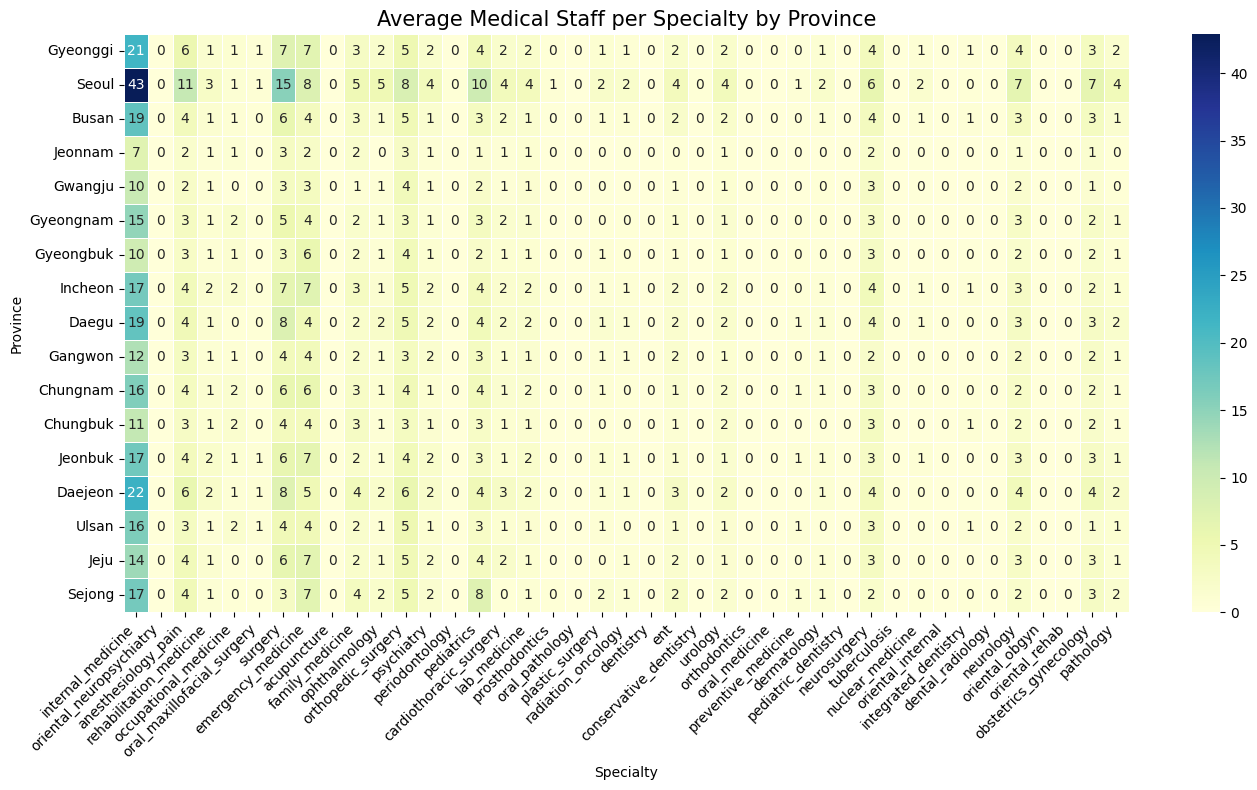

In [ ]:

# === Set index and extract specialty columns only ===
region_heatmap_df = region_specialty_df.set_index('province_en')[specialty_cols]

# === Plot full heatmap for all specialties by region ===
plt.figure(figsize=(14, 8))
sns.heatmap(region_heatmap_df, cmap='YlGnBu', annot=True, fmt=".0f", linewidths=0.5)

plt.title("Average Medical Staff per Specialty by Province", fontsize=15)
plt.xlabel("Specialty")
plt.ylabel("Province")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


+ Top 10 Specialties Only – Heatmap

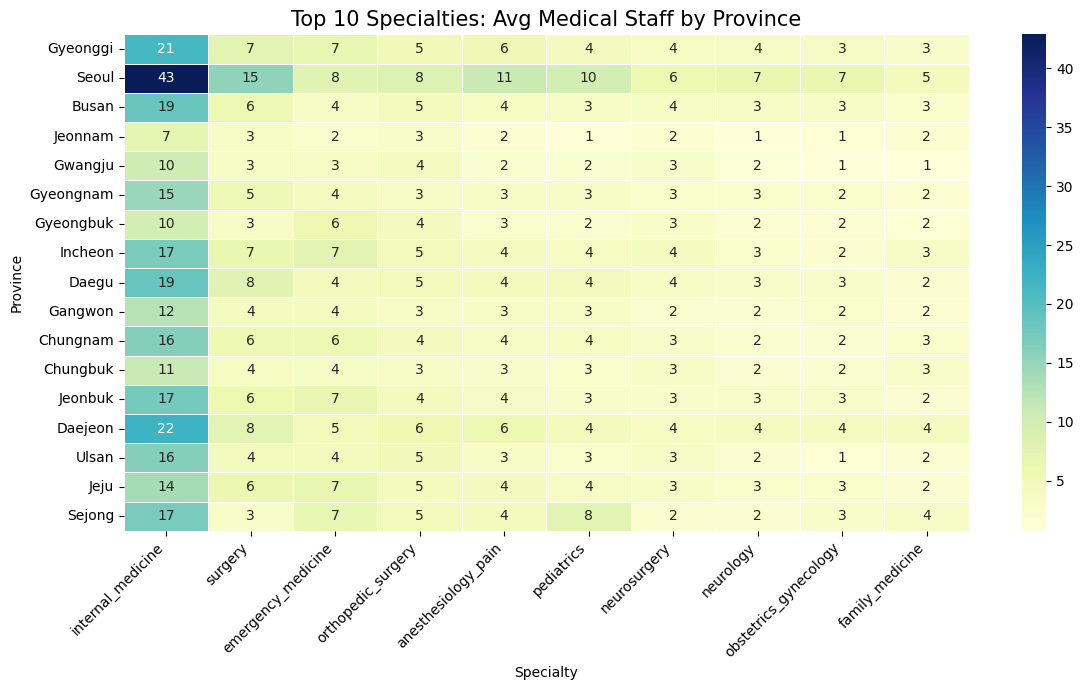

In [78]:
# === Identify top 10 most frequent specialties ===
top_specialty_cols = region_specialty_df.iloc[:, 3:-2].sum().sort_values(ascending=False).head(10).index.tolist()

# === Filter and plot only top 10 specialties ===
top_region_heatmap_df = region_specialty_df.set_index('province_en')[top_specialty_cols]

plt.figure(figsize=(12, 7))
sns.heatmap(top_region_heatmap_df, cmap='YlGnBu', annot=True, fmt=".0f", linewidths=0.5)
plt.title("Top 10 Specialties: Avg Medical Staff by Province", fontsize=15)
plt.xlabel("Specialty")
plt.ylabel("Province")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### 3.3.2 Barplot – Focused Specialty (Internal Medicine)

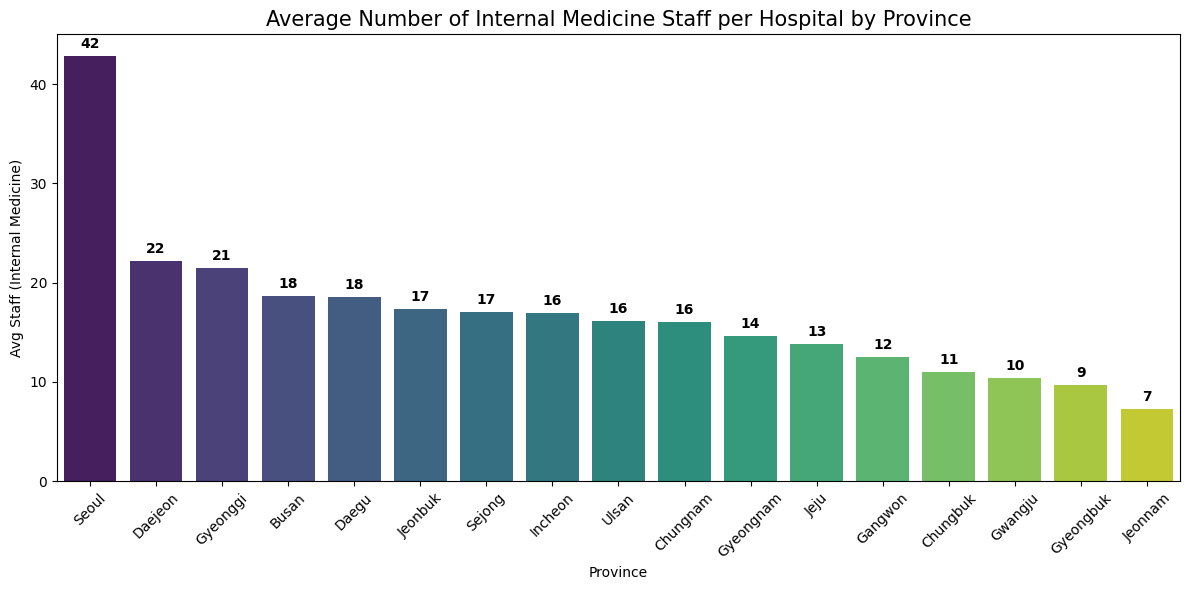

In [89]:
# === Sort by average internal medicine staff and plot bar chart ===
plt.figure(figsize=(12, 6))
barplot2 = sns.barplot(
    data=region_specialty_df.sort_values(by='internal_medicine', ascending=False),
    x='province_en',
    y='internal_medicine',
    palette='viridis'
)

# === Add label above each bar ===
for i, row in region_specialty_df.sort_values(by="internal_medicine", ascending=False).reset_index().iterrows():
    barplot2.text(
        i,
        row["internal_medicine"] + 0.5,  # Slight gap above bar
        s=f"{int(row['internal_medicine'])}",
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.xticks(rotation=45)
plt.title("Average Number of Internal Medicine Staff per Hospital by Province", fontsize=15)
plt.ylabel("Avg Staff (Internal Medicine)")
plt.xlabel("Province")
plt.tight_layout()
plt.show()